In [ ]:
!pip3 install -r requirements.txt

In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from PIL import Image

import re
from typing import List

In [164]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/filip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Analiza podataka
-  Podaci se nalaze u direktorijumu `dataset`  

-  Podaci su vec podeljeni na train i test skup tako da nema potrebe koristiti neku od ugradjenih funkcija (npr. `train_test_split` iz `sklearn.model_selection` paketa)  

In [299]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [300]:
def autopct_format_all(x: np.float64) -> str:
    num_instances = train_data.shape[0] if x > 60 else test_data.shape[0]

    return f'{num_instances}\n({x:.2f}%)'

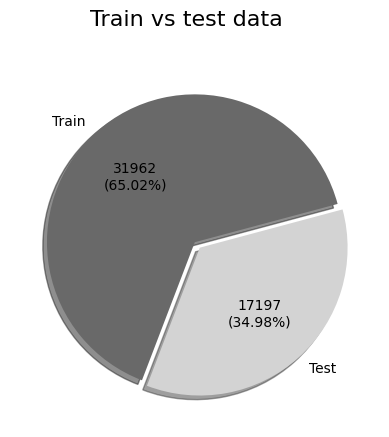

In [301]:
labels = 'Train', 'Test'
sizes = [train_data.shape[0], test_data.shape[0]]

# Koriscenjem karaktera ';' na kraju poziva metode pie sprecava jupyter notebook da ispisuje adrese u memoriji
(fig, ax) = plt.subplots()
fig.suptitle(t='Train vs test data', fontsize=16)

ax.pie(
    x=sizes,
    explode=(0, 0.05),
    labels=labels, 
    colors=['dimgray', 'lightgray'], 
    autopct=autopct_format_all,
    shadow=True, 
    startangle=15
);

<h1 style="text-align:center"> Train podaci </h1> 

In [302]:
(num_instances, num_attrs) = train_data.shape
attrs = [attr for attr in train_data.columns]

print(f'Broj instanci: {num_instances:,}')
print(f'Broj atributa: {num_attrs} ({", ".join(attrs)})')

Broj instanci: 31,962
Broj atributa: 3 (id, label, tweet)


In [303]:
(non_hatred, hatred) = train_data['label'].value_counts()
hatred_perc = hatred / (train_data.shape[0]) * 100
non_hatred_perc = non_hatred / (train_data.shape[0]) * 100

print(colored(
    'Broj instanci odnosno broj tweet-ova koji su okaraksterisani kao govor mrznje: '\
    f'{hatred:,} ({hatred_perc:.2f}%)', 
    'red')
)
print(colored(
    'Broj instanci odnosno broj tweet-ova koji nisu okarakterisani kao govor mrznje: '\
    f'{non_hatred:,} ({non_hatred_perc:.2f}%)', 
    'green')
)

Broj instanci odnosno broj tweet-ova koji su okaraksterisani kao govor mrznje: 2,242 (7.01%)
Broj instanci odnosno broj tweet-ova koji nisu okarakterisani kao govor mrznje: 29,720 (92.99%)


In [304]:
pd.set_option('display.max_colwidth', 1000)

train_data.head(n=10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,10,0,@user @user welcome here ! i'm it's so #gr8 !


Kako je atributan `id` irelevantan mozemo da izbaciti iz DataFrame-a

In [305]:
train_data.drop(['id'], axis=1, inplace=True)

train_data.head(n=10)

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦
9,0,@user @user welcome here ! i'm it's so #gr8 !


### Obrada null vrednosti (nedostajucih vrednosti)

In [306]:
null_values = train_data.isna().any().any()

print('Nema null vrednosti') if not null_values else train_data.isna().sum()

Nema null vrednosti


#### Neke od metoda za obradjivanje null vrednosti
Kako nas skup ne sadrzi null vrednosti nema potrebe za daljom analizom nedostajucih podataka  
U slucaju da su postojale null vrednosti one su mogle biti obradjene na neki od sledecih nacina:  
-  **`Izbacivanjem`** (*train_data.dropna()*, pri cemu moramo voditi racuna da ne izbacimo previse podataka)  

-  **`Popunjavanjem default vrednostima`** (*train_data.fillna(def)*, ovde se postavlja pitanje sta izabrati kao default vrednost, u slucaju da nemamo vrednost za *label* atribut ako izaberemo 0 tweet-ovi koji sadrze govor mrznje mogu biti okarakaterisani kao tweet-ovi koji ne sadrze govor mrznje, slicno za 1)  

- **`Popunjavanje unapred / unazad`** (*train_data['label'].ffill()*, odnosno *train_data['label'].bfill()*)
    -  *ffill()* popunjava null vrednost na osnovu vrednosti koja se nalazi iznad nje
    -  *bfill()* popunjava null vrednost na osnovu vrednosti koja se nalazi ispod nje
- **...**

Nakon popunjavanja nedostajucih vrednosti mozemo iskoristiti metod `hist()` kako bi proverili koliko smo zaista uticali na nas set podataka  

Iako nas skup podataka nema null vrednosti treba obraditi tweet-ove na taj nacin da ne sadrze `stopwords` ('I', 'myself', 'your', 'like' ...), `znakove interpunkcije` (',', '!', '.' ...), `emojis` (':)', ';)', ...) i sl. sto ne moze znacajnije uticati na tekst

In [308]:
stop_words = set(stopwords.words('english'))
stop_words.add('user')

lemma = WordNetLemmatizer()

In [309]:
def preprocessing_tweet(tweet: str) -> str:
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'[^a-zA-Z]', ' ', new_tweet)   # Zameni sve sto nije slovo sa ' '
    new_tweet = [word for word in new_tweet.split() if word not in stop_words]
    new_tweet = ' '.join([lemma.lemmatize(word) for word in new_tweet])
    
    return new_tweet

In [310]:
train_data['tweet_cleaned'] = train_data['tweet'].apply(preprocessing_tweet)

train_data.head(n=10)

,label,tweet,tweet_cleaned
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,model love u take u time ur
4,0,factsguide: society now #motivation,factsguide society motivation
5,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,huge fan fare big talking leave chaos pay dispute get allshowandnogo
6,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,next school year year exam think school exam hate imagine actorslife revolutionschool girl
8,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,love land allin cavs champion cleveland clevelandcavaliers
9,0,@user @user welcome here ! i'm it's so #gr8 !,welcome gr


## Vizuelni prikaz train podataka

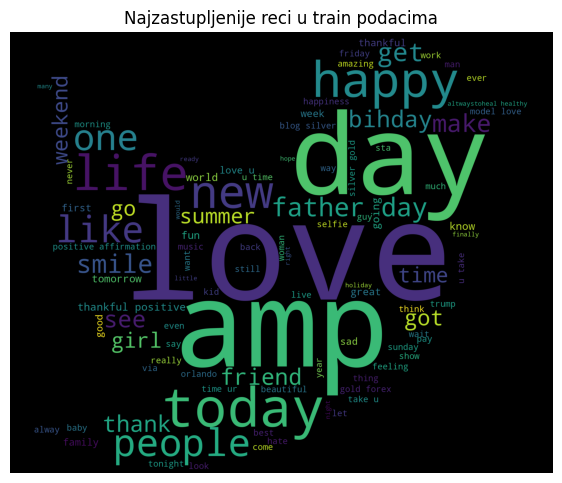

In [375]:
all_tweets_img = np.array(Image.open('images/all_tweets.png'))

all_tweets = ' '.join(train_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=all_tweets_img,
).generate(all_tweets)

plt.title('Najzastupljenije reci u train podacima')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

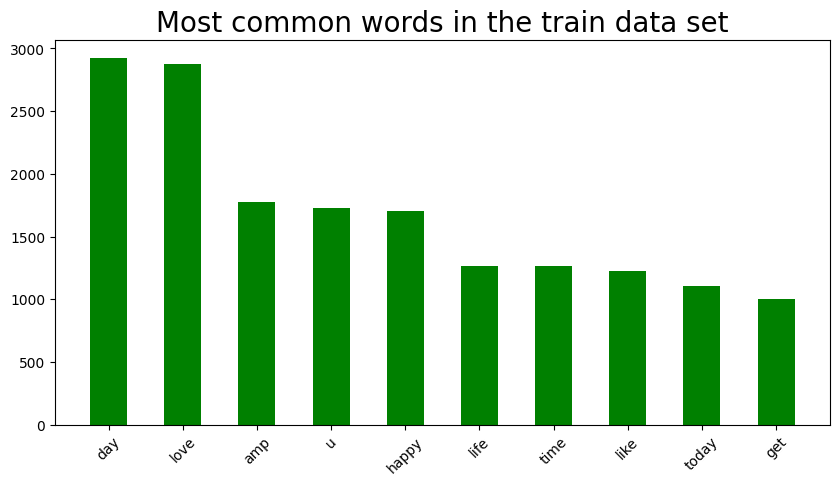

In [376]:
all_words = FreqDist(
    ' '.join(train_data['tweet_cleaned']).split()
).most_common(10)

all_words_data = pd.DataFrame(all_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    all_words_data['words'].tolist(), 
    all_words_data['frequency'].tolist(), 
    width=0.5, 
    color='green'
)

plt.title('Most common words in the train data set', fontsize=20)
plt.xticks(rotation=45)
plt.show()

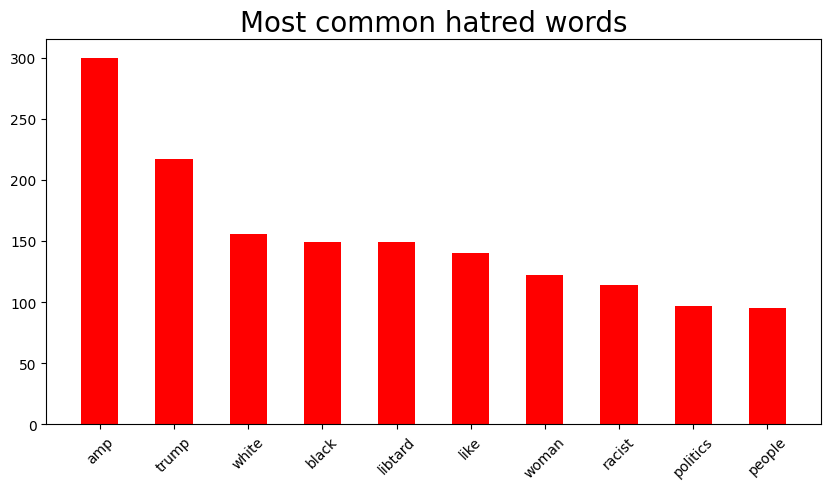

In [346]:
hatred_words = FreqDist(
    ' '.join(hatred_tweets['tweet_cleaned']).split()
).most_common(10)

hatred_df = pd.DataFrame(hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    hatred_df['words'].tolist(), 
    hatred_df['frequency'].tolist(), 
    width=0.5, 
    color='red'
)

plt.title('Most common hatred words', fontsize=20)
plt.xticks(rotation=45)
plt.show()

### Vizuelni prikaz `Hatred vs Non-Hatred` tweet-ova

In [382]:
def autopct_format(x: np.float64) -> str:
    broj_instanci = int(train_data.shape[0] * x / 100)
    
    return f'{broj_instanci}\n({x:.2f}%)'

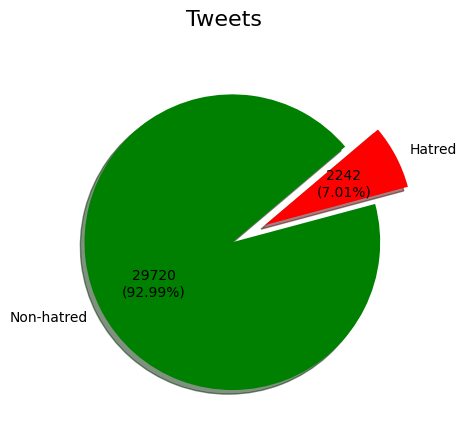

In [383]:
labels = 'Hatred', 'Non-hatred'
sizes = [
    sum(train_data['label'] == 1),
    sum(train_data['label'] == 0)
]

fig, ax = plt.subplots()
fig.suptitle(t='Tweets', fontsize=16)

ax.pie(
    x=sizes, 
    explode=(0.25, 0),
    labels=labels, 
    colors=['Red', 'Green'], 
    autopct=autopct_format,
    shadow=True, 
    startangle=15
);

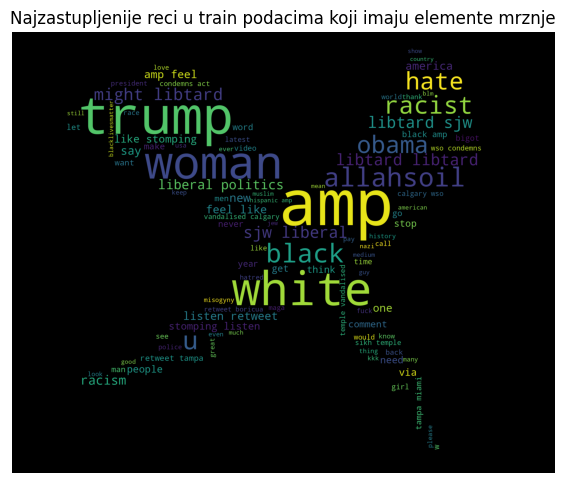

In [389]:
hatred_tweets_img = np.array(Image.open('images/hatred_tweets.png'))
hatred_tweets_data = train_data[train_data['label'] == 1]

hatred_tweets = ' '.join(hatred_tweets_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=hatred_tweets_img,
).generate(hatred_tweets)

plt.title('Najzastupljenije reci u train podacima koji imaju elemente mrznje')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

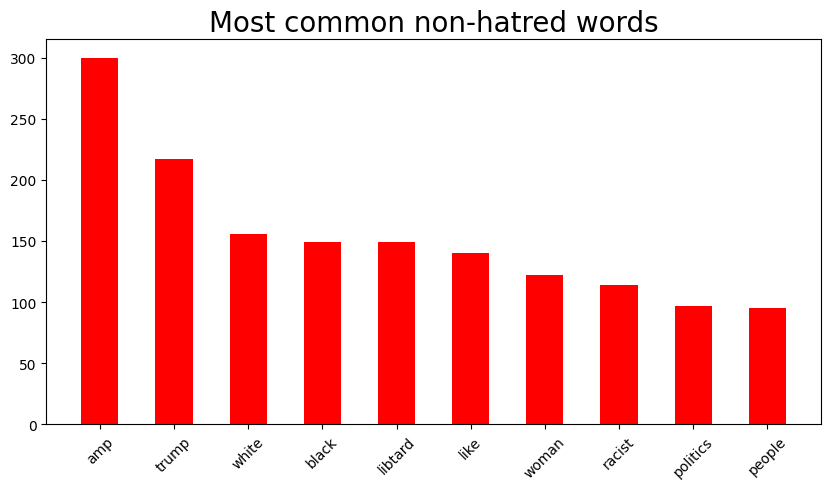

In [387]:
hatred_words = FreqDist(
    ' '.join(hatred_tweets_data['tweet_cleaned']).split()
).most_common(10)

hatred_df = pd.DataFrame(hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    hatred_df['words'].tolist(), 
    hatred_df['frequency'].tolist(), 
    width=0.5, 
    color='red'
)

plt.title('Most common non-hatred words', fontsize=20)
plt.xticks(rotation=45)
plt.show()

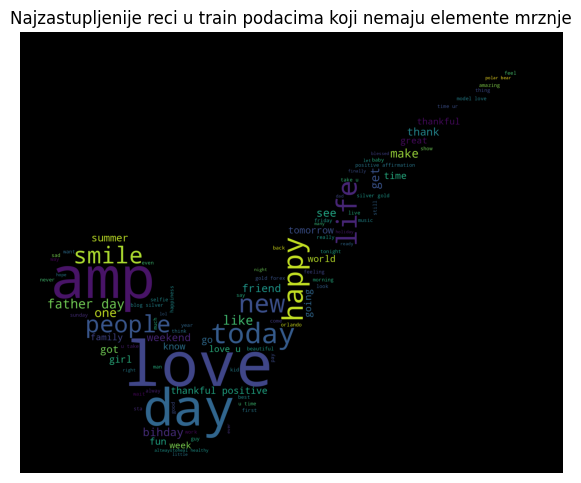

In [390]:
non_hatred_tweets_img = np.array(Image.open('images/non-hatred_tweets.png'))
non_hatred_tweets_data = train_data[train_data['label'] == 0]

non_hatred_tweets = ' '.join(non_hatred_tweets_data['tweet_cleaned'].tolist())

plt.figure(figsize=(7, 7))
wordcloud = WordCloud(
    stopwords=stop_words,
    max_words=100,
    mask=non_hatred_tweets_img,
).generate(non_hatred_tweets)

plt.title('Najzastupljenije reci u train podacima koji nemaju elemente mrznje')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

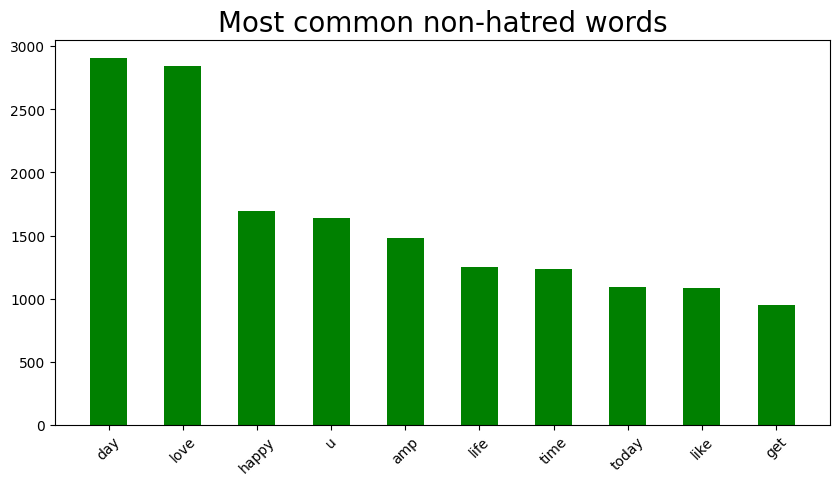

In [393]:
non_hatred_words = FreqDist(
    ' '.join(non_hatred_tweets_data['tweet_cleaned']).split()
).most_common(10)

non_hatred_df = pd.DataFrame(non_hatred_words, columns=['words', 'frequency'])

fig = plt.figure(figsize=(10,5))
plt.bar(
    non_hatred_df['words'].tolist(), 
    non_hatred_df['frequency'].tolist(), 
    width=0.5, 
    color='green'
)

plt.title('Most common non-hatred words', fontsize=20)
plt.xticks(rotation=45)
plt.show()

<h1 style="text-align:center"> Test podaci </h1> 

In [101]:
test_data.head(n=10)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"
5,31968,choose to be :) #momtips
6,31969,something inside me dies ð¦ð¿â¨ eyes ness #smokeyeyes #tired #lonely #sof #grungeâ¦
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸â¤ï¸â¤ï¸â¤ï¸ #thanks#aleeee !!!
8,31971,@user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels
9,31972,#delicious #food #lovelife #capetown mannaepicure #resturantâ¦


In [102]:
# Atribut 'id' je ireleventan za nas skup pa ga mozemo izbaciti
test_data.drop(['id'], axis=1, inplace=True)

test_data.head(n=10)

,tweet
0,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"
5,choose to be :) #momtips
6,something inside me dies ð¦ð¿â¨ eyes ness #smokeyeyes #tired #lonely #sof #grungeâ¦
7,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸â¤ï¸â¤ï¸â¤ï¸ #thanks#aleeee !!!
8,@user @user @user i will never understand why my dad left me when i was so young.... :/ #deep #inthefeels
9,#delicious #food #lovelife #capetown mannaepicure #resturantâ¦


In [86]:
(broj_instanci, broj_atributa) = test_data.shape
atributi = [attr for attr in test_data.columns]

print(f'Broj instanci: {broj_instanci:,}')
print(f'Broj atributa: {broj_atributa} ({", ".join(atributi)})')

Broj instanci: 17,197
Broj atributa: 1 (tweet)


### Obrada null vrednosti (nedostajucih vrednosti)

In [93]:
null_vrednosti = test_data.isna().any().any()

print('Nema null vrednosti') if not null_vrednosti else test_data.isna().sum()

Nema null vrednosti
